In [1]:
!pip install tensorflow matplotlib --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 29.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.2 which is incompatible.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(layer, activation='tanh') for layer in layers[:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, x):
        z = x
        for layer in self.hidden_layers:
            z = layer(z)
        return self.output_layer(z)

# Define the differential equation to be solved
def f_u(x, model):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
    u_x = tape.gradient(u, x)
    return u_x

# Define the loss function
def loss(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        u = model(x)
        u_x = f_u(x, model)
        loss_value = tf.reduce_mean(tf.square(u_x - tf.sin(x)))
    return loss_value

# Training step
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value


In [3]:
# Generate training data
x_train = np.linspace(0, np.pi, 100)[:, None]
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0: Loss = 0.7868816256523132
Epoch 100: Loss = 0.30548879504203796
Epoch 200: Loss = 0.15147879719734192
Epoch 300: Loss = 0.007066118530929089
Epoch 400: Loss = 0.006350163370370865
Epoch 500: Loss = 0.006306737195700407
Epoch 600: Loss = 0.006272312253713608
Epoch 700: Loss = 0.0062354872934520245
Epoch 800: Loss = 0.006196049507707357
Epoch 900: Loss = 0.006154183764010668
Epoch 1000: Loss = 0.00611003115773201
Epoch 1100: Loss = 0.006063723471015692
Epoch 1200: Loss = 0.0060153682716190815
Epoch 1300: Loss = 0.005965085234493017
Epoch 1400: Loss = 0.005912983324378729
Epoch 1500: Loss = 0.005859212949872017
Epoch 1600: Loss = 0.005803919397294521
Epoch 1700: Loss = 0.005747261457145214
Epoch 1800: Loss = 0.005689351353794336
Epoch 1900: Loss = 0.005630269180983305
Epoch 2000: Loss = 0.005569981876760721
Epoch 2100: Loss = 0.00550824822857976
Epoch 2200: Loss = 0.005444579292088747
Epoch 2300: Loss = 0.005378124304115772
Epoch 2400: Loss = 0.005307570565491915
Epoch 2500: Loss

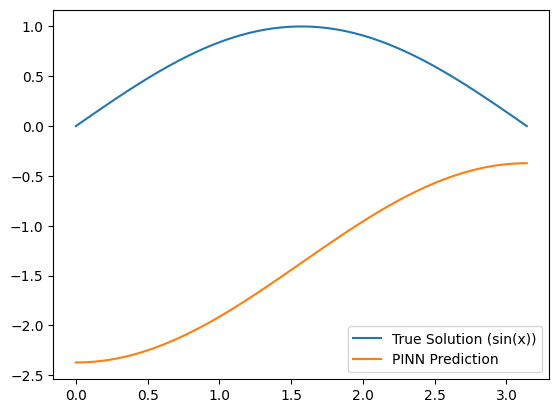

In [4]:
# Hyperparameters
layers = [1, 20, 20, 1]
learning_rate = 0.001
epochs = 10000

# Instantiate the model and optimizer
model = PINN(layers)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training loop
for epoch in range(epochs):
    loss_value = train_step(model, x_train, optimizer)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")

# Plot the results
x_test = np.linspace(0, np.pi, 100)[:, None]
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
u_pred = model(x_test)

plt.plot(x_test, np.sin(x_test), label='True Solution (sin(x))')
plt.plot(x_test, u_pred, label='PINN Prediction')
plt.legend()
plt.show()


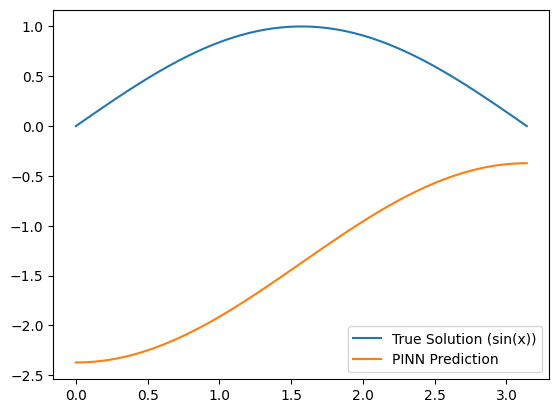

In [5]:
# Evaluate the model
u_pred = model(x_test)
plt.plot(x_test, np.sin(x_test), label='True Solution (sin(x))')
plt.plot(x_test, u_pred, label='PINN Prediction')
plt.legend()
plt.show()
